In [1]:
import os
import sys
sys.path.append("../")

import hydra
from omegaconf import DictConfig
import pandas as pd
import torch
from src.utils.preprocess import (
    load_tif_seq_data,
    match_with_genomic_data,
    save_processed_data,
    preprocess_data,
    get_tokens
)
from src.training.data_module import YeastDataModule
from src.utils.dataset import one_hot_encode_sequence as one_hot, split_by_chrom
from src.utils.utils import set_seed
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import math
from src.models.lora import Lora
import pytorch_lightning as pl
import torch

from captum.attr import DeepLift

%load_ext autoreload
%autoreload 2
set_seed(42)

Seed set to 42


In [2]:
# Function to load Hydra configuration
base_dir = os.getcwd()
os.environ["CURRENT_DIR"] = base_dir


def load_config(config_path: str, config_name: str) -> DictConfig:
    with hydra.initialize(config_path=config_path, version_base="1.3"):
        config = hydra.compose(config_name=config_name)
    return config


# Load the configuration
config = load_config(config_path="../configs", config_name="lora")

# Load the data

In [3]:
# Preprocessing Data
data_dir = config.data.data_dir
data_dir = "../" + data_dir
tif_seq_file_path = os.path.join(data_dir, config.data.tif_seq_file)
dataset_file_path = os.path.join(data_dir, config.data.dataset_file)
counts_file = os.path.join(data_dir, config.data.counts_file)
preprocessed_file = os.path.join(data_dir, config.data.preprocessed_file)

# chage cwd to the root directory
os.chdir(base_dir)
print(f"Current working directory: {os.getcwd()}")
print(f"counts_file: {counts_file}")

tif_df = load_tif_seq_data(tif_seq_file_path)
if not os.path.exists(counts_file) or not os.path.exists(preprocessed_file):
    dataset, counts = match_with_genomic_data(tif_df, dataset_file_path)
    save_processed_data(counts, dataset, counts_file, preprocessed_file)

print("Preprocessing completed successfully!")

# Load preprocessed data
counts = torch.load(counts_file)
dataset = pd.read_parquet(preprocessed_file)

print(f"Loaded counts shape: {counts.shape}")
print(f"Loaded dataset shape: {dataset.shape}")

# Splitting Data and Creating Data Loaders
train_idx, val_idx, test_idx, one_hots, counts, dataset = preprocess_data(
    dataset,
    counts,
    True,
    config.data.seq_col,
    set(config.data.val_chroms),
    set(config.data.test_chroms),
)

tokens = get_tokens(dataset)

data_module = YeastDataModule(
    batch_size=config.training.batch_size,
    train_idx=train_idx,
    val_idx=val_idx,
    test_idx=test_idx,
    data=tokens,
    counts=counts,
)

data_module.setup()

Current working directory: /data/ceph/hdd/project/node_07/ml4rg_students/2024/Project07_PolyB/Regulate-Me/notebooks
counts_file: ../data/saccharomyces_cerevisiae/counts.pt
Preprocessing completed successfully!
Loaded counts shape: torch.Size([6580, 2, 1003])
Loaded dataset shape: (6580, 10)


Map (num_proc=4):   0%|          | 0/6580 [00:00<?, ? examples/s]

test


# Load the model

In [4]:
model = Lora.load_from_checkpoint('../data/best_models/lora.ckpt')
model.eval()

Lora(
  (embedding_model): PeftModelForTokenClassification(
    (base_model): LoraModel(
      (model): BertForMaskedLM(
        (bert): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(5504, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0-11): 12 x BertLayer(
                (attention): BertAttention(
                  (self): BertSdpaSelfAttention(
                    (query): lora.Linear(
                      (base_layer): Linear(in_features=768, out_features=768, bias=True)
                      (lora_dropout): ModuleDict(
                        (default): Dropout(p=0.1, inplace=False)
                      )
                      (

In [5]:
# import summary
from torchinfo import summary
print(summary(model, input_data=tokens[0:2]))

Layer (type:depth-idx)                                                      Output Shape              Param #
Lora                                                                        [2, 2, 295]               --
├─PeftModelForTokenClassification: 1-1                                      [2, 298, 768]             --
│    └─LoraModel: 2-1                                                       [2, 298, 768]             --
│    │    └─BertForMaskedLM: 3-1                                            --                        90,865,280
├─Conv1d: 1-2                                                               [2, 512, 295]             1,180,160
├─BatchNorm1d: 1-3                                                          [2, 512, 295]             1,024
├─Conv1d: 1-4                                                               [2, 256, 295]             393,472
├─BatchNorm1d: 1-5                                                          [2, 256, 295]             512
├─Conv1d: 1-6             

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(
        "gagneurlab/SpeciesLM", revision="downstream_species_lm"
    )


pad_token_id = tokenizer.pad_token_id
# Define the reference token size like tokens[0] filled with pad_token_id
ref_token  = torch.full_like(tokens[0], pad_token_id)

In [7]:
import pytorch_lightning as pl

class ModelWrapper(pl.LightningModule):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, x):
        outputs = self.model(x)
        # Assume outputs is a tuple of tensors
        #concatenated_output = torch.cat(outputs, dim=1)
        return outputs[0]

Get DL attributions with respect to embedding layer

In [8]:
from captum.attr import LayerDeepLift

wrapped_model = ModelWrapper(model)
dl = LayerDeepLift(wrapped_model, model.embedding_model.bert.embeddings)

In [9]:
val_tokens = tokens[val_idx]
val_one_hots = one_hots[val_idx]

In [10]:
baselines = ref_token.unsqueeze(0)

attributions, delta = dl.attribute(
    inputs=val_tokens, baselines=baselines, return_convergence_delta=True, target=(0,0)
)

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (0) is identical to the `bos_token_id` (0), `eos_token_id` (None), or the `sep_token_id` (None), and your input is not padded.


Get kmer_attributions from embedding attributions

In [11]:
kmer_attributions = torch.sum(attributions, dim=2)

# remove star seq tok, species tok, end seq tok
clippied_kmer_attributions = kmer_attributions[:,2 : -1]

Get one hot attributions from kmer attributions

In [12]:
def kmer_to_one_hot_attribution(kmer_attributions, one_hots, k=6, stride=1):
    attributions = torch.zeros_like(one_hots)
    _, n_kmers = kmer_attributions.shape

    sequences, _, _ = one_hots.shape
    for seq in range(sequences):
        for i in range(0, n_kmers, stride):
            kmer_attribution = kmer_attributions[seq, i]
            for j in range(k):
                attributions[seq, :, i + j] += one_hots[seq, :, i + j] * kmer_attribution

    return attributions

In [13]:
testing_one_hots = val_one_hots
testing_one_hots = testing_one_hots.double()

attr = kmer_to_one_hot_attribution(kmer_attributions=clippied_kmer_attributions, one_hots=testing_one_hots)

In [14]:
input_batch_np = val_one_hots.detach().numpy()
attribution_np = attr.detach().numpy()

print(input_batch_np.shape)
print(attribution_np.shape)

(498, 4, 300)
(498, 4, 300)


In [15]:
# save the attribution and input batch
np.save("../data/input_batch.npy", input_batch_np)
np.save("../data/attribution.npy", attribution_np)

In [16]:
import modiscolite

pos_patterns, neg_patterns = modiscolite.tfmodisco.TFMoDISco(
    hypothetical_contribs=attribution_np.transpose((0, 2, 1)),
    one_hot=input_batch_np.transpose((0, 2, 1)),
    max_seqlets_per_metacluster=1000000,
    sliding_window_size=5,#5 is working
    flank_size=3,
    target_seqlet_fdr=0.25,
    n_leiden_runs=3,
    verbose=True,
    trim_to_window_size=20,
    initial_flank_to_add=5,
    final_min_cluster_size = 3
)

modiscolite.io.save_hdf5("../data/modisco_results1.h5", pos_patterns, neg_patterns, window_size=20)

Using 527 positive seqlets
Extracted 436 negative seqlets


In [25]:
!modisco report -i ../data/modisco_results1.h5 -o ../data/report/

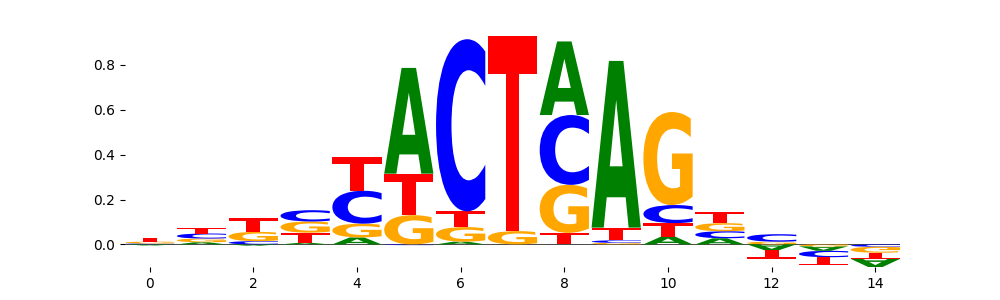

In [26]:
from IPython.display import Image

Image('../data/report/trimmed_logos/pos_patterns.pattern_0.cwm.fwd.png')

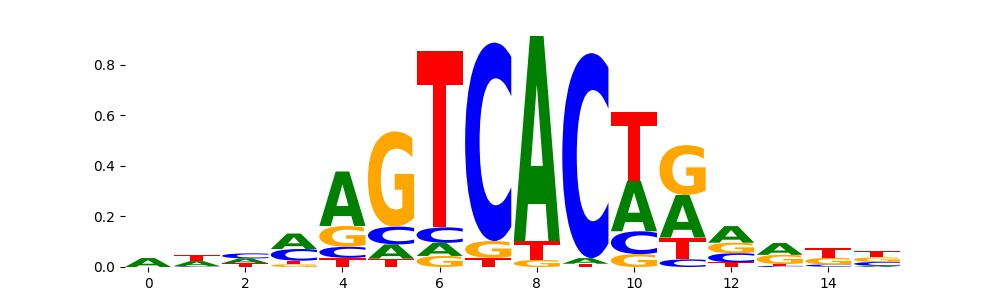

In [27]:
Image('../data/report/trimmed_logos/pos_patterns.pattern_1.cwm.fwd.png')